 # Tutorial: Retrieving Mapillary Street-Level Images in Dublin Using Google Colab

 Negin Zarbakhsh, PhD candiate, School of Computer Science, UCD


**Objective**
In this tutorial, you'll learn how to retrieve street-level images from the Mapillary API for the city of Dublin using Python in Google Colab.

**Prerequisites**
*  A Google account
*  Familiarity with Python
*  A Mapillary API key





# How to Get Mapillary API?

1- Open [Mapillary Website](https://www.mapillary.com/)

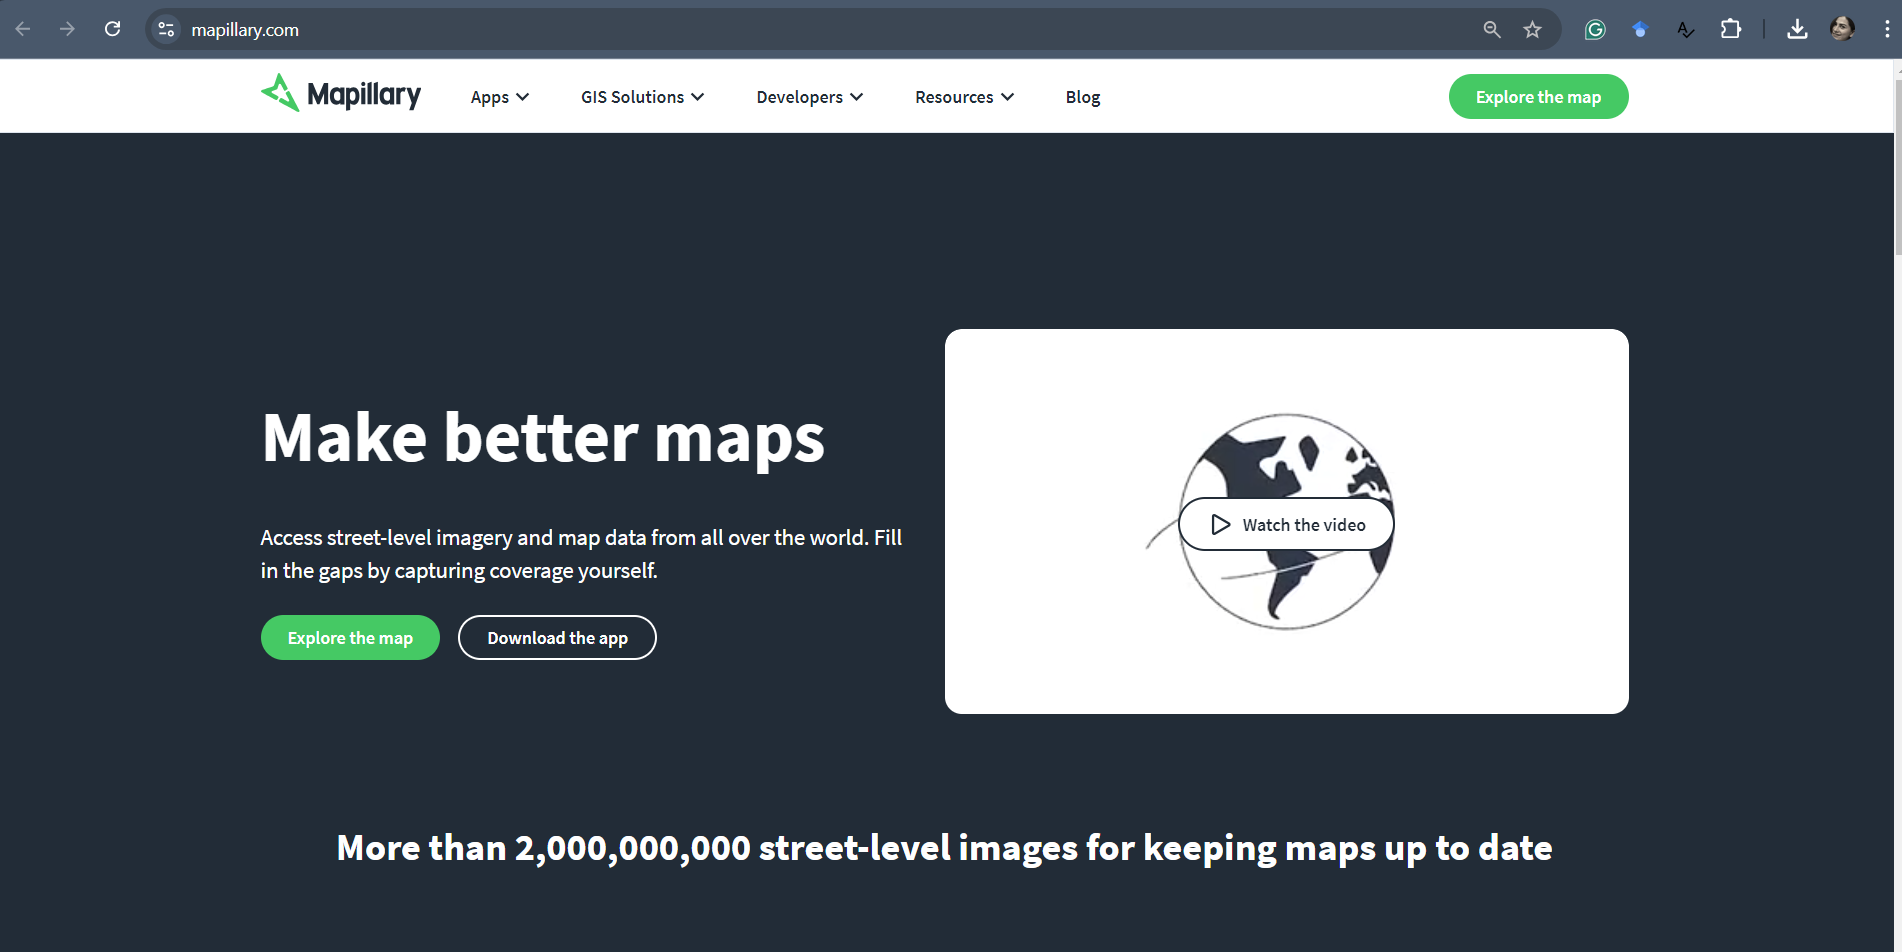

2- Click on Explore the Map
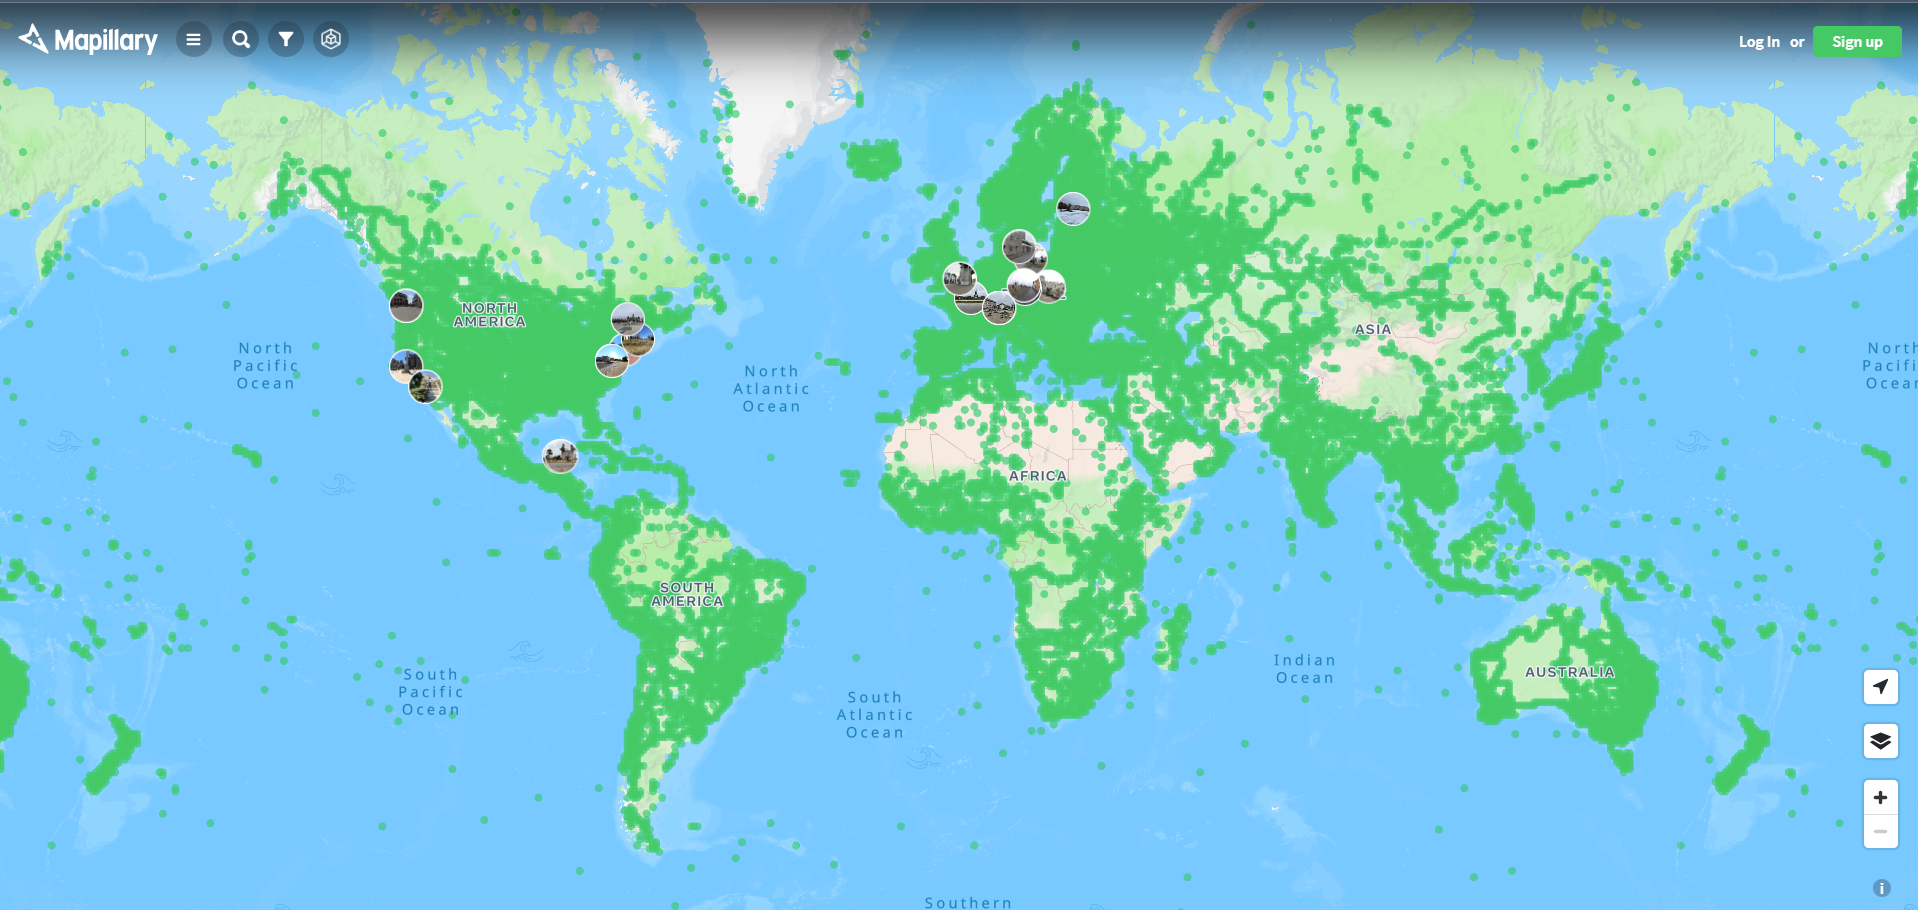

3- Sign Up and then go to your dashboard. Register your application in Developer part and copy your token

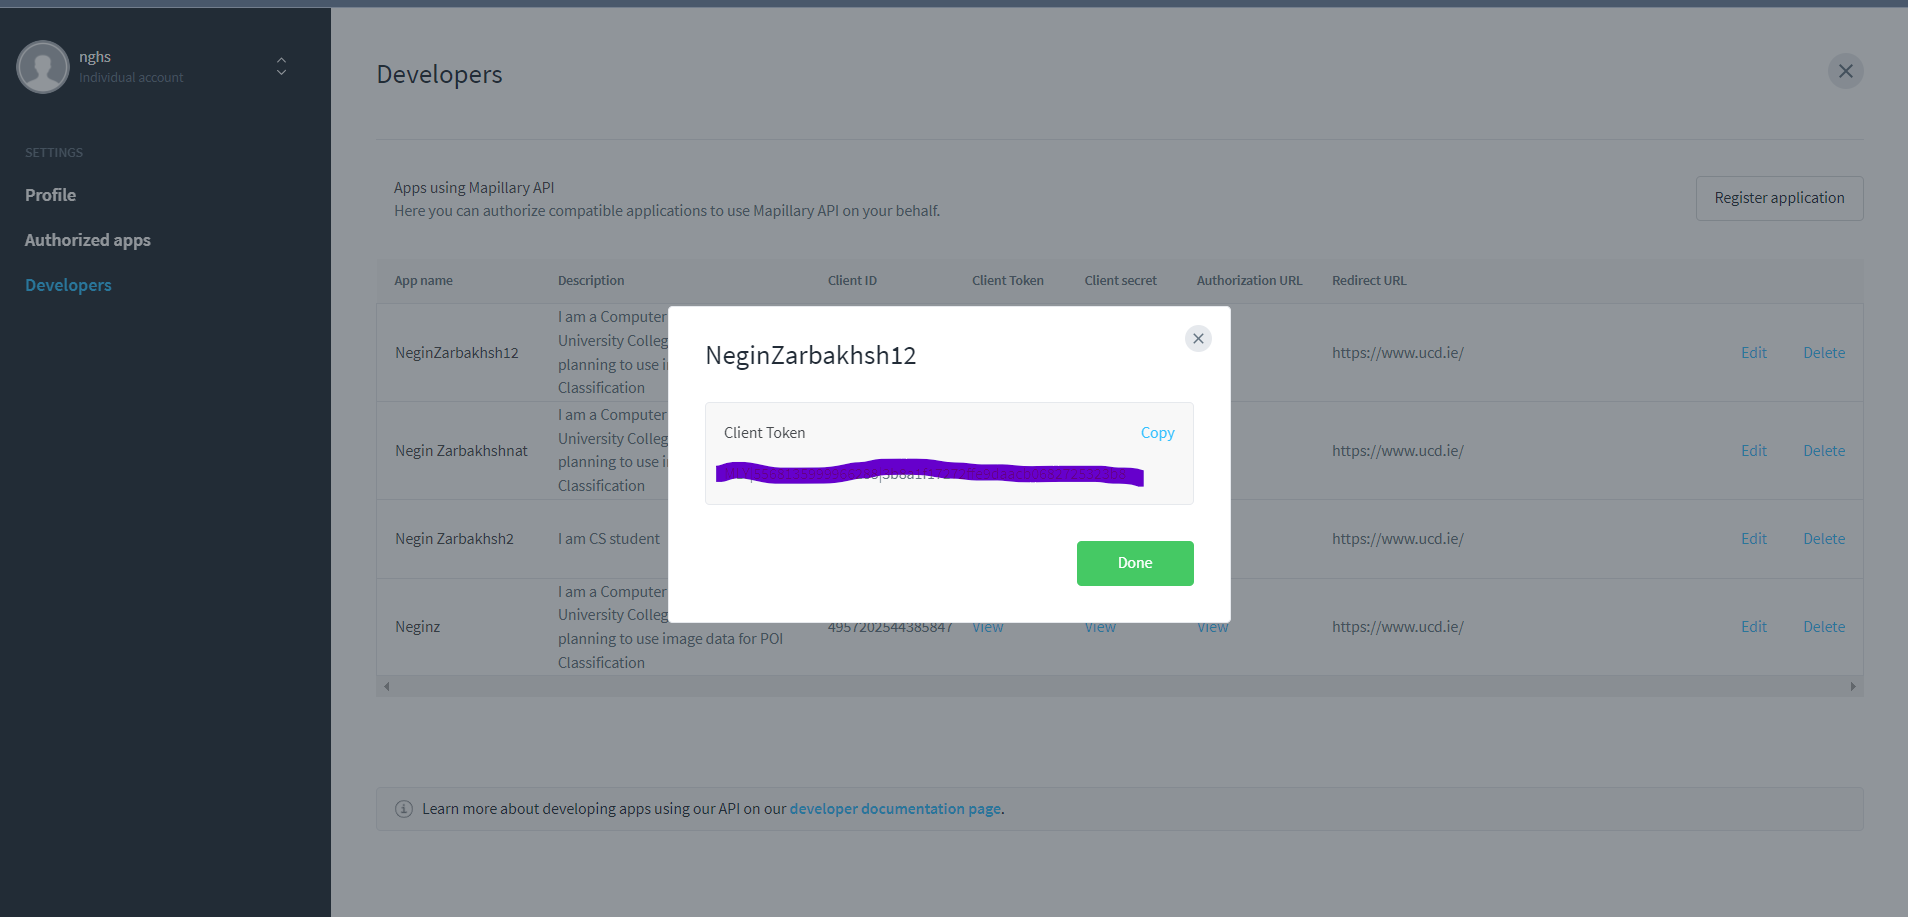

## Step 1: Setting Up the Google Colab Environment

Install Required Libraries: Mapillary’s API requires a few libraries to handle requests and data. Run the following command to install the necessary packages:

In [33]:
!pip install requests
!pip install Mapillary


In [34]:
import mapillary.interface as mly  # a specific tool for interacting with Mapillary,
import pandas as pd #powerful tool for data manipulation
import json #Allows us to work with JSON data, which is a common format for storing structured information
import time #Provides time-related functions, such as delays or getting the current time
from tqdm import tqdm  # Adds a progress bar to our loops, which helps us track long-running processes.
from datetime import datetime #Helps work with dates and times
import os #Lets us interact with the operating system, like working with files or directories.
import requests # Allows us to send HTTP requests, like getting data from a website.
from requests.exceptions import HTTPError, RequestException
import folium #A library used to create interactive maps.
import matplotlib.pyplot as plt # Allows us to create visualizations and charts easily
from PIL import Image #From the Pillow library, used to work with images, like opening or processing them


# Step 2: Authenticate with the Mapillary API

1. Add Your API Key: To authenticate with the Mapillary API, insert your API key into the following code cell. Replace 'your_api_key_here' with your actual API key.

2. Test Your Authentication: Let’s perform a quick test to ensure that the API key works. Run this code to get the details of your authenticated user:

In [35]:
#This line defines an access token as a string. The access token is like a password that gives you permission to use the Mapillary API. It allows you to request data and interact with Mapillary services.
access_token = ""
# prove that you have permission to access the data
mly.set_access_token(access_token)


{'token': 'SUCCESS'}

# Step 2: Define the Coordinates of Interest
We will start by defining the coordinates (latitude and longitude) of the locations for which we want to retrieve Mapillary images. This is done using a Python dictionary and converted to a pandas DataFrame for easier handling.

In [36]:
# Coordinates data (add your coordinates to this section)
coordinates_data = {
    'name': ['Eamonn Ceannt Park', 'Fusion Fitness', 'Shelton GRV Road'], #name: The name of each location.
    'latitude': [53.3240707414798, 53.315512,53.312887972727],#latitude and longitude: The geographic coordinates for the locations.
    'longitude': [-6.29292691228124, -6.3005545,-6.3103935272727]
}
# Create a DataFrame for easier manipulation of the data
df = pd.DataFrame(coordinates_data)
df

name   latitude  longitude
0  Eamonn Ceannt Park  53.324071  -6.292927
1      Fusion Fitness  53.315512  -6.300554
2    Shelton GRV Road  53.312888  -6.310394

# Step 3: Download Mapillary Metadata for Each Location
Now that we have the coordinates of interest, we’ll use the Mapillary API to retrieve image metadata close to those locations. We define a function to do this and save the metadata in a JSON file.

In [37]:
# Function to convert Unix timestamp to a human-readable date format
def convert_timestamp(timestamp):
    """
    Convert a Unix timestamp (a number representing a specific point in time)) (in milliseconds) to a human-readable date format (YYYY-MM-DD HH:MM:SS).

    Args:
    - timestamp: Unix timestamp in milliseconds.

    Returns:
    - Formatted date as a string or 'Unknown' if the timestamp is not valid.
    """
    if isinstance(timestamp, int): #Checks if the timestamp is an integer (a valid Unix timestamp).
        return datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S') #Converts the timestamp (in milliseconds) to a human-readable date in UTC.
    return 'Unknown' #: If timestamp is not a valid integer, return 'Unknown'.


# Function to download Mapillary metadata for images close to specified locations
def download_mapillary_metadata(dataframe):
    """
    Download metadata for Mapillary images close to the specified latitude and longitude coordinates.

    Args:
    - dataframe: A pandas DataFrame containing the 'name', 'latitude', and 'longitude' columns.

    Returns:
    - None: Saves the metadata as a JSON file with details about the images found near the coordinates.
    """


    # Create an empty list to store metadata for each image found
    image_metadata_list = [] #Creates an empty list to store the metadata for each image that will be found.

    # Iterate over each row in the dataframe (each location)
    for index, row in tqdm(dataframe.iterrows(), total=dataframe.shape[0], desc="Processing Locations"): # Iterates over each row in the dataframe and uses tqdm to show the progress
        try:
            print(f"\nFetching images for {row['name']} at {row['latitude']}, {row['longitude']}")

            # Fetch images within a 50m radius around the given coordinates (you can adjust the radius as needed)
            images_data = mly.get_image_close_to(
                latitude=row['latitude'],
                longitude=row['longitude'],
                radius=50,  # Adjust the radius based on your requirement (50 meters here)
                min_captured_at="2024-01-01",  # Fetch images captured after this date (YYYY-MM-DD)
                image_type="pano"  # Fetch panoramic images (can change to 'flat' for regular images)
            ).to_dict()

            # Iterate over the images found and store the relevant metadata
            for feature in images_data['features']:
                # Extract the latitude and longitude coordinates of the image
                lat = feature['geometry']['coordinates'][1]
                lon = feature['geometry']['coordinates'][0]

                # Convert the captured_at timestamp to a human-readable format
                captured_at_timestamp = feature['properties'].get('captured_at', 'Unknown')
                captured_at_formatted = convert_timestamp(captured_at_timestamp)

                # Append the metadata of the image to the list
                image_metadata_list.append({
                    'name': row['name'],  # The name of the location from the dataframe
                    'latitude': lat,  # Latitude of the image
                    'longitude': lon,  # Longitude of the image
                    'image_id': feature['properties']['id'],  # Unique ID of the image
                    'captured_at': captured_at_formatted  # Human-readable capture date of the image
                })

            print(f"\nImages found for {row['name']}: {len(images_data['features'])} images")

        except HTTPError as e: #Handles possible errors, like HTTP or other request-related issues, and prints an error message. The loop then continues to the next location.
            print(f"HTTP error at {row['name']} ({row['latitude']}, {row['longitude']}): {e}")
            continue
        except RequestException as e:
            print(f"Request error at {row['name']} ({row['latitude']}, {row['longitude']}): {e}")
            continue

    # Save the metadata to a JSON file
    with open("mapillary_metadata.json", 'w') as outfile: #opens a file named "mapillary_metadata.json" in write mode.
        json.dump(image_metadata_list, outfile, indent=4)

    print(f"Metadata saved to mapillary_metadata.json with {len(image_metadata_list)} entries.")

# Apply the function to the DataFrame
download_mapillary_metadata(df)


Processing Locations:   0%|          | 0/3 [00:00<?, ?it/s]


Fetching images for Eamonn Ceannt Park at 53.3240707414798, -6.29292691228124
Requesting GET to https://tiles.mapillary.com/maps/vtp/mly1_public/2/14/7905/5312/?access_token=MLY%7C5568135999966288%7C3b8a1f17272ffe9daacb0682725323b8


INFO:mapillary.utils.client:Requesting GET to https://tiles.mapillary.com/maps/vtp/mly1_public/2/14/7905/5312/?access_token=MLY%7C5568135999966288%7C3b8a1f17272ffe9daacb0682725323b8


Response 200 OK received in 781ms


INFO:mapillary.utils.client:Response 200 OK received in 781ms
Processing Locations:  33%|███▎      | 1/3 [00:34<01:08, 34.41s/it]


Images found for Eamonn Ceannt Park: 62 images

Fetching images for Fusion Fitness at 53.315512, -6.3005545
Requesting GET to https://tiles.mapillary.com/maps/vtp/mly1_public/2/14/7905/5313/?access_token=MLY%7C5568135999966288%7C3b8a1f17272ffe9daacb0682725323b8


INFO:mapillary.utils.client:Requesting GET to https://tiles.mapillary.com/maps/vtp/mly1_public/2/14/7905/5313/?access_token=MLY%7C5568135999966288%7C3b8a1f17272ffe9daacb0682725323b8


Response 200 OK received in 180ms


INFO:mapillary.utils.client:Response 200 OK received in 180ms
Processing Locations:  67%|██████▋   | 2/3 [00:41<00:18, 18.44s/it]


Images found for Fusion Fitness: 0 images

Fetching images for Shelton GRV Road at 53.312887972727, -6.3103935272727
Requesting GET to https://tiles.mapillary.com/maps/vtp/mly1_public/2/14/7904/5313/?access_token=MLY%7C5568135999966288%7C3b8a1f17272ffe9daacb0682725323b8


INFO:mapillary.utils.client:Requesting GET to https://tiles.mapillary.com/maps/vtp/mly1_public/2/14/7904/5313/?access_token=MLY%7C5568135999966288%7C3b8a1f17272ffe9daacb0682725323b8


Response 200 OK received in 149ms


INFO:mapillary.utils.client:Response 200 OK received in 149ms
Processing Locations: 100%|██████████| 3/3 [00:45<00:00, 15.10s/it]


Images found for Shelton GRV Road: 22 images
Metadata saved to mapillary_metadata.json with 84 entries.


# Step 4: Downloading Images Using Mapillary Metadata

Now that we have the metadata for the images, we will:

Read the metadata from the JSON file.
Download each image based on its metadata and save it to a local directory.

In [38]:
#We used the metadata to download the actual images and save them locally.
# Function to download images from Mapillary using metadata
def download_mapillary_images(metadata_file_path, images_directory):
    """
    Download images from Mapillary given a JSON file of metadata.

    Args:
    - metadata_file_path: The file path to the Mapillary metadata JSON.
    - images_directory: The directory path where images will be saved.

    """
    # Load metadata from the JSON file
    with open(metadata_file_path, 'r') as file:
        metadata = json.load(file)
      # Define the request headers with the authorization token
    headers = {'Authorization': f'OAuth {access_token}'}
    # Ensure the directory to store images exists
    if not os.path.exists(images_directory):
        os.makedirs(images_directory)
        print(f"Directory '{images_directory}' created successfully")

    # Iterate over metadata and download images
    for image_metadata in tqdm(metadata, desc="Downloading Images"):
        image_id = image_metadata['image_id']
        try:
            # Request image URL
            image_url_request = f'https://graph.mapillary.com/{image_id}?fields=thumb_2048_url' #Using the image_id, a request URL is created. The Mapillary API is asked to provide the URL for a high-resolution image (thumb_2048_url).
            response = requests.get(image_url_request, headers=headers) #A request is sent to the API to fetch the image information. The headers contain the API authorization token.
            response.raise_for_status()  # Check if the request was successful

            # Extract image URL from response
            image_url = response.json().get('thumb_2048_url')

            # Download the image and save it
            if image_url:
                image_path = os.path.join(images_directory, f"{image_id}.jpg")
                with requests.get(image_url, stream=True) as image_response:
                    with open(image_path, 'wb') as image_file:
                        for chunk in image_response.iter_content(chunk_size=8192): #The image is downloaded in chunks (8192 bytes at a time) to prevent memory issues when handling large files.
                            image_file.write(chunk)
                print(f"Image {image_id} downloaded successfully")
            else:
                print(f"No image URL found for {image_id}")

        except requests.exceptions.RequestException as e:
            print(f"Error downloading image {image_id}: {e}")

# Example usage
metadata_file_path = 'mapillary_metadata.json'  # Path to your metadata file
images_directory = 'downloaded_images/'  # Directory to save images
download_mapillary_images(metadata_file_path, images_directory)


Image 402941362300541 downloaded successfully


Image 1821354831608337 downloaded successfully


Image 3878653582358069 downloaded successfully


Image 497385509371089 downloaded successfully


Image 3726021714352995 downloaded successfully


Image 2683179581843165 downloaded successfully


Image 1195544154817380 downloaded successfully


Image 451395587732814 downloaded successfully


Image 1315271742979271 downloaded successfully


Image 1570719527133914 downloaded successfully


Image 1625748651604954 downloaded successfully


Image 1032519988309417 downloaded successfully


Image 3163818367086786 downloaded successfully


Image 887382760098909 downloaded successfully


Image 1031336274647838 downloaded successfully


Image 448607701481705 downloaded successfully


Image 500712182499991 downloaded successfully


Image 472416695742787 downloaded successfully


Image 516391710898302 downloaded successfully


Image 1225298838485014 downloaded successfully


Image 411128424731340 downloaded successfully


Image 1014156763577563 downloaded successfully


Image 512844994750826 downloaded successfully


Image 1847766622364733 downloaded successfully


Image 2014569635666846 downloaded successfully


Image 850883589889909 downloaded successfully


Image 1414601139206993 downloaded successfully


Image 881683540442714 downloaded successfully


Image 790570813265117 downloaded successfully


Image 1940826413051245 downloaded successfully


Image 472467662404818 downloaded successfully


Image 830951725767928 downloaded successfully


Image 459272483654205 downloaded successfully


Image 903429564926412 downloaded successfully


Image 1158301128805395 downloaded successfully


Image 1566416430637241 downloaded successfully


Image 1217627992707630 downloaded successfully


Image 1383649598970639 downloaded successfully


Image 443169228715718 downloaded successfully


Image 1407778989916840 downloaded successfully


Image 1183053576258674 downloaded successfully


Image 1815962312263055 downloaded successfully


Image 3670432823271011 downloaded successfully


Image 1029646518094885 downloaded successfully


Image 749896877169479 downloaded successfully


Image 791524736449435 downloaded successfully


Image 7480875335350389 downloaded successfully


Image 450477024639568 downloaded successfully


Image 1203847287319828 downloaded successfully


Image 681165434207094 downloaded successfully


Image 861260338839607 downloaded successfully


Image 525759093133821 downloaded successfully


Image 1407573096604114 downloaded successfully


Image 811485271106204 downloaded successfully


Image 514403544384318 downloaded successfully


Image 3737137393229531 downloaded successfully


Image 1019653349611266 downloaded successfully


Image 1676993653126970 downloaded successfully


Image 850719783787481 downloaded successfully


Image 912891320857912 downloaded successfully


Image 3488207411325633 downloaded successfully


Image 450567201131710 downloaded successfully


Image 2174733516232870 downloaded successfully


Image 1237317377254627 downloaded successfully


Image 445394748296115 downloaded successfully


Image 2353989454790949 downloaded successfully


Image 3854827701462796 downloaded successfully


Image 452349110916225 downloaded successfully


Image 1694950057983040 downloaded successfully


Image 7795539077229291 downloaded successfully


Image 1392384728115910 downloaded successfully


Image 464868716175915 downloaded successfully


Image 1157033762295649 downloaded successfully


Image 458247736842684 downloaded successfully


Image 892329802731224 downloaded successfully


Image 497355086306234 downloaded successfully


Image 1172385437410812 downloaded successfully


Image 1165855191422647 downloaded successfully


Image 840222550925587 downloaded successfully


Image 2676308222551748 downloaded successfully


Image 349964314622520 downloaded successfully


Image 1215015049515515 downloaded successfully


Image 455639130550763 downloaded successfully


Image 835826811401251 downloaded successfully


In [39]:
# Load the JSON metadata file
with open('/content/mapillary_metadata.json', 'r') as file:
    data = json.load(file)

# Extract the latitude, longitude, and name from the JSON file
locations = []
for item in data:
    locations.append({
        'name': item['name'],
        'latitude': item['latitude'],
        'longitude': item['longitude'],
        'image_id': item['image_id'],
        'captured_at': item['captured_at']
    })

# Create a pandas DataFrame for easier manipulation
df = pd.DataFrame(locations)

# Initialize a map centered around the first location
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=14)

# Add markers to the map
for _, row in df.iterrows():
    popup_info = f"Location: {row['name']}<br>Image ID: {row['image_id']}<br>Captured At: {row['captured_at']}"
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=popup_info
    ).add_to(m)

# Save the map to an HTML file and display it
m.save("mapillary_metadata_map.html")

# Display the map in the notebook (if you're using a Jupyter notebook)
m


# Step 5: Loading the Image Data

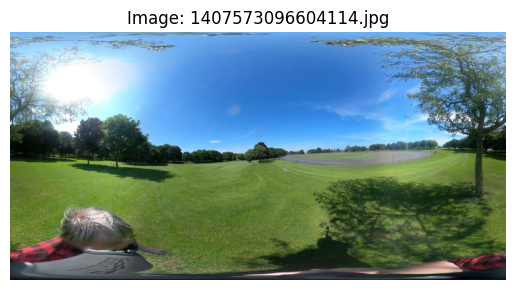

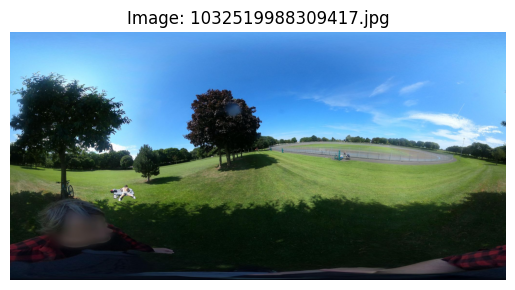

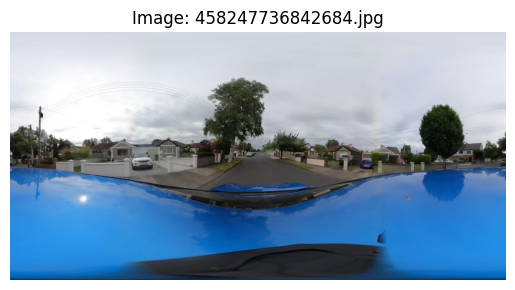

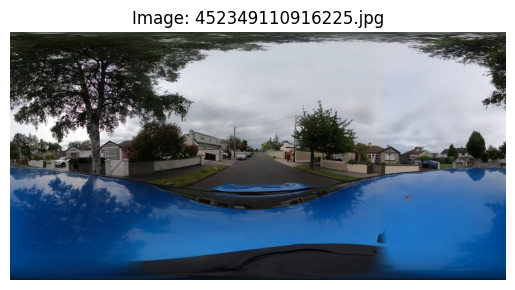

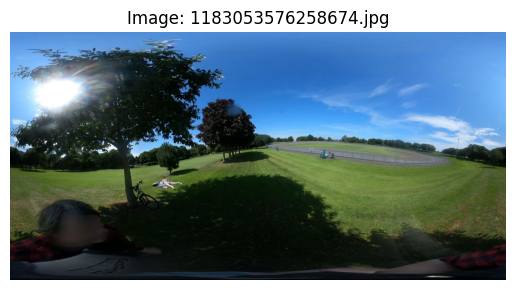

In [40]:
# Directory where the images are stored
image_directory = '/content/downloaded_images'

# List the images in the directory
image_files = os.listdir(image_directory)

# Display the first few images using Matplotlib
for image_file in image_files[:5]:  # Adjust the number of images to display
    image_path = os.path.join(image_directory, image_file)
    img = Image.open(image_path)

    # Plot the image
    plt.imshow(img)
    plt.title(f"Image: {image_file}")
    plt.axis('off')  # Turn off axis labels
    plt.show()


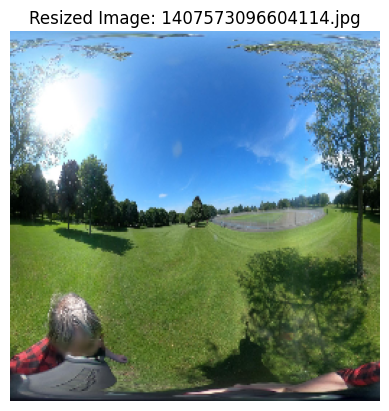

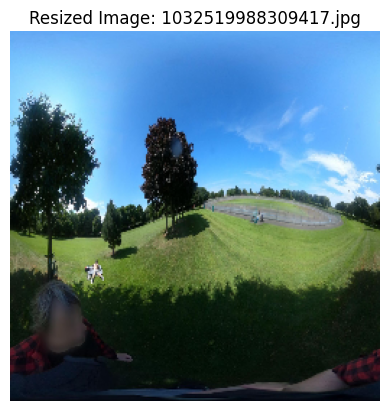

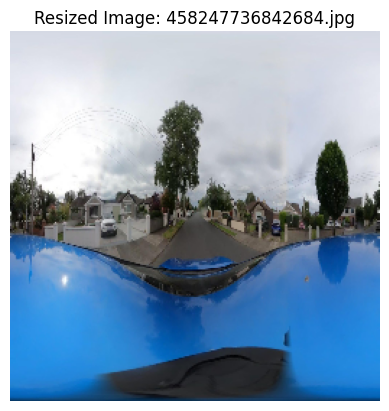

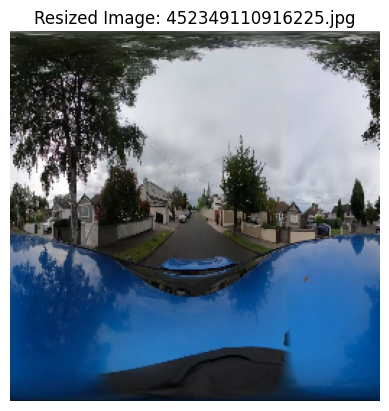

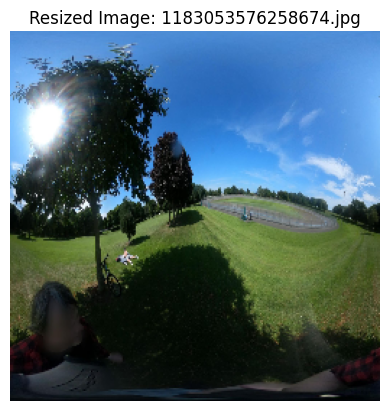

In [41]:
import cv2

# Function to resize and display images
def resize_and_display(image_path, new_size=(256, 256)): #Input: The path of an image (image_path) and the new size to which the image will be resized (new_size=(256, 256)).
    img = cv2.imread(image_path) #The image is read using OpenCV (cv2.imread()).

    # Resize the image
    resized_img = cv2.resize(img, new_size) #The image is resized to the specified dimensions using cv2.resize()

    # Display the resized image
    plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)) #The image is converted from BGR (OpenCV default color format) to RGB using cv2.cvtColor() since Matplotlib uses RGB for displaying images.
    plt.title(f"Resized Image: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

# Display resized versions of the first few images
for image_file in image_files[:5]:
    image_path = os.path.join(image_directory, image_file)
    resize_and_display(image_path)
